In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import torchvision
import torchvision.transforms as transforms
import time
from PIL import Image

In [3]:
search_area = np.array([
    [0,1],
    [1,0]
])

curr_mb = np.array([
    [0,1],
    [1,0]
])

In [4]:
def inter16x(sa, cur):
    
    def ldps(sa_):
        safety = 1000
        vec = [0,0]
        while safety > 0:
            min_sad = [256**2, (1,1)]
            mid_x = sa_[0] + vec[0]
            mid_y = sa_[1] + vec[1]
            for mvx, mvy in ([0,1], [1,0], [0,-1], [-1,0], [0,0]):
                x_ = mid_x + mvx
                y_ = mid_y + mvy
                org_ = search_area[y_:y_+16, x_:x_+16]
                sad = int(sum(abs(org_.flatten() - curr_mb.flatten())))
                if sad <= min_sad[0]:
                    min_sad = [sad, (mvx, mvy)]
            if min_sad[1] == (0,0):
                return (min_sad[0], mid_x, mid_y)
            else:
                vec[0] += min_sad[1][0]
                vec[1] += min_sad[1][1]
            safety -= 1
        return (256**2, -1, -1)
    
    return ldps(sa)
    

In [232]:
def intra4x(cur, neighbors, valid_IL, valid_EH, valid_AD, valid_M):
    for i in range(13):
        if type(neighbors[i]) is not int:
            neighbors[i] = neighbors[i].astype(int)
    A, B, C, D, E, F, G, H, I, J, K, L, M = neighbors
    eq0 = (A + B + 1) >> 1
    eq1 = (B + C + 1) >> 1
    eq2 = (C + D + 1) >> 1
    eq3 = (D + E + 1) >> 1
    eq4 = (E + F + 1) >> 1
    eq5 = (F + G + 1) >> 1
    eq6 = (G + H + 1) >> 1
    eq7 = (I + J + 1) >> 1
    eq8 = (J + K + 1) >> 1
    eq9 = (K + L + 1) >> 1
    eq10 = (M + A + 1) >> 1
    eq11 = (M + I + 1) >> 1
    eq12 = (2*H + 1) >> 1
    eq13 = (2*L + 1) >> 1
    eq14 = (eq0 + eq10) >> 1
    eq15 = (eq0 + eq1) >> 1
    eq16 = (eq1 + eq2) >> 1
    eq17 = (eq2 + eq3) >> 1
    eq18 = (eq3 + eq4) >> 1
    eq19 = (eq4 + eq5) >> 1
    eq20 = (eq5 + eq6) >> 1
    eq21 = (eq7 + eq11) >> 1
    eq22 = (eq7 + eq8) >> 1
    eq23 = (eq8 + eq9) >> 1
    eq24 = (eq10 + eq11) >> 1
    eq25 = (eq6 + eq12) >> 1
    eq26 = (eq9 + eq13) >> 1
    eq27 = (eq0 + eq2) >> 1
    eq28 = (eq7 + eq9) >> 1
    eq29 = (eq27 + eq28) >> 1
    
    modes = [
        [A, B, C, D, A, B, C, D, A, B, C, D, A, B, C, D],
        [I, I, I, I, J, J, J, J, K, K, K, K, L, L, L, L],
        [eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29, eq29],
        [eq15, eq16, eq17, eq18, eq16, eq17, eq18, eq19, eq17, eq18, eq19, eq20, eq18, eq19, eq20, eq25],
        [eq24, eq14, eq15, eq16, eq21, eq24, eq14, eq15, eq22, eq21, eq24, eq14, eq23, eq22, eq21, eq24],
        [eq10, eq0, eq1, eq2, eq24, eq14, eq15, eq16, eq21, eq10, eq0, eq1, eq22, eq24, eq14, eq15],
        [eq11, eq24, eq14, eq15, eq7, eq21, eq11, eq24, eq8, eq22, eq7, eq21, eq9, eq23, eq8, eq22],
        [eq0, eq1, eq2, eq3, eq15, eq16, eq17, eq18, eq1, eq2, eq3, eq4, eq16, eq17, eq18, eq19],
        [eq7, eq22, eq8, eq23, eq8, eq23, eq9, eq26, eq9, eq26, L, L, L, L, L, L]
    ]
    
    valid_modes = []
    if valid_AD:
        valid_modes.append(0)
    if valid_IL:
        valid_modes.append(1)
    if valid_AD and valid_IL:
        valid_modes.append(2)
    if valid_AD and valid_IL and valid_EH and valid_M:
        valid_modes.append(3)
    if valid_AD and valid_IL and valid_M:
        valid_modes.extend([4, 5, 6])
    if valid_AD and valid_EH:
        valid_modes.append(7)
    if valid_IL:
        valid_modes.append(8)
    
    sad = []
    pred_blocks = []
    for i, mode in enumerate(modes):
        if i in valid_modes:
            pred = np.zeros((4, 4, 3), dtype=np.uint8)
            for j in range(4):
                for k in range(4):
                    pred[j][k] = mode[j*4 + k]
            sad.append(int(sum(abs(cur.flatten() - pred.flatten()))))
            pred_blocks.append(pred)
    
    sad_best = min(sad)
    best_mode = valid_modes[sad.index(sad_best)]
    pred_block = pred_blocks[sad.index(sad_best)]
    diff_block = pred_block - cur
    
    return sad_best, best_mode, pred_block, diff_block

In [216]:
def intra16x(cur, neighbors_H, neighbors_V, valid_H, valid_V):
    sad = []
    pred_blocks = []
    if valid_H:
        pred = np.zeros((16, 16, 3), dtype=np.uint8)
        for i, val in enumerate(neighbors_H):
            pred[:, i] = val
        sad.append(int(sum(abs(cur.flatten() - pred.flatten()))))
        pred_blocks.append(pred)
    else:
        sad.append(256**2)
        pred_blocks.append(np.zeros((16,16)))
        
    if valid_V:
        pred = np.zeros((16, 16, 3), dtype=np.uint8)
        for i, val in enumerate(neighbors_V):
            pred[i] = [val]*16
        sad.append(int(sum(abs(cur.flatten() - pred.flatten()))))
        pred_blocks.append(pred)
    else:
        sad.append(256**2)
        pred_blocks.append(np.zeros((16,16)))
        
    if valid_H and valid_V:
        r_total = g_total = b_total = 0
        for i in range(15):
            r_total += int(neighbors_H[i][0]) + int(neighbors_V[i][0])
            g_total += int(neighbors_H[i][1]) + int(neighbors_V[i][1])
            b_total += int(neighbors_H[i][2]) + int(neighbors_V[i][2])
        val = [r_total // 30, g_total // 30, b_total // 30]
        pred = np.full((16, 16, 3), val, dtype=np.uint8)
        sad.append(int(sum(abs(cur.flatten() - pred.flatten()))))
        pred_blocks.append(pred)
    else:
        sad.append(256**2)
        pred_blocks.append(np.zeros((16,16)))
        
    sad_best = min(sad)
    best_mode = sad.index(sad_best)
    pred_block = pred_blocks[best_mode]

    return sad_best, best_mode, cur, pred_block

In [7]:
def ICT(residuals):
    reg_bank = np.zeros((4,4))
    for i in range(4):
        wire0 = residuals[i][0] + residuals[i][3]
        wire1 = residuals[i][1] + residuals[i][2]
        wire2 = residuals[i][1] - residuals[i][2]
        wire3 = residuals[i][0] - residuals[i][3]
        reg_bank[:, i][0] = wire0 + wire1
        reg_bank[:, i][1] = wire2 + (2 * wire3)
        reg_bank[:, i][2] = wire0 - wire1
        reg_bank[:, i][3] = wire3 - (2 * wire2)
        
    out = np.zeros((4,4))
    for i in range(4):
        wire0 = reg_bank[:, i][0] + reg_bank[:, i][3]
        wire1 = reg_bank[:, i][1] + reg_bank[:, i][2]
        wire2 = reg_bank[:, i][1] - reg_bank[:, i][2]
        wire3 = reg_bank[:, i][0] - reg_bank[:, i][3]
        out[i][0] = wire0 + wire1
        out[i][1] = wire2 + (2 * wire3)
        out[i][2] = wire0 - wire1
        out[i][3] = wire3 - (2 * wire2)
        
    return out

In [8]:
def IICT(data):
    reg_bank = np.zeros((4,4))
    for i in range(4):
        wire0 = residuals[i][0] + residuals[i][2]
        wire1 = residuals[i][0] - residuals[i][2]
        wire2 = (residuals[i][1] // 2) - residuals[i][3]
        wire3 = residuals[i][1] + (residuals[i][3] // 2)
        reg_bank[:, i][0] = wire0 + wire3
        reg_bank[:, i][1] = wire1 + wire2
        reg_bank[:, i][2] = wire1 - wire2
        reg_bank[:, i][3] = wire0 - wire3
        
    out = np.zeros((4,4))
    for i in range(4):
        wire0 = reg_bank[:, i][0] + reg_bank[:, i][2]
        wire1 = reg_bank[:, i][0] - reg_bank[:, i][2]
        wire2 = (reg_bank[:, i][1] // 2) - reg_bank[:, i][3]
        wire3 = reg_bank[:, i][1] + (reg_bank[:, i][3] // 2)
        out[i][0] = wire0 + wire3
        out[i][1] = wire1 + wire2
        out[i][2] = wire1 - wire2
        out[i][3] = wire0 - wire3
        
    return out

In [9]:
def HT(residuals):
    reg_bank = np.zeros((4,4))
    for i in range(4):
        wire0 = residuals[i][0] + residuals[i][3]
        wire1 = residuals[i][1] + residuals[i][2]
        wire2 = residuals[i][1] - residuals[i][2]
        wire3 = residuals[i][0] - residuals[i][3]
        reg_bank[:, i][0] = wire0 + wire1
        reg_bank[:, i][1] = wire2 + wire3
        reg_bank[:, i][2] = wire0 - wire1
        reg_bank[:, i][3] = wire3 - wire2
        
    out = np.zeros((4,4))
    for i in range(4):
        wire0 = residuals[:, i][0] + residuals[:, i][3]
        wire1 = residuals[:, i][1] + residuals[:, i][2]
        wire2 = residuals[:, i][1] - residuals[:, i][2]
        wire3 = residuals[:, i][0] - residuals[:, i][3]
        out[i][0] = wire0 + wire1
        out[i][1] = wire2 + wire3
        out[i][2] = wire0 - wire1
        out[i][3] = wire3 - wire2
        
    return out

In [10]:
def quant_AC(coeff, qp, qstep):
    mf = np.full((4, 4), 5243)
    mf[0][0] = 8192
    mf[0][2] = 8192
    mf[2][0] = 8192
    mf[2][2] = 8192
    mf[1][1] = 3355
    mf[1][3] = 3355
    mf[3][1] = 3355
    mf[3][3] = 3355
    qbits = 15 + qp // 6
    quantized = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            quantized[i][j] = (coeff[i][j] * mf[i][j]) >> qbits
            
    return quantized

In [11]:
def quant_DC(coeff, qp, qstep):
    mf = 8192
    qbits = 15 + qp // 6
    quantized = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            quantized[i][j] = (coeff[i][j] * mf) >> (qbits + 1)
            if coeff[i][j] < 0: quantized[i][j] = -abs(quantized[i][j])
            else: quantized[i][j] = abs(quantized[i][j])
                
    return quantized

In [12]:
def inverse_quant_AC(quantized, qp):
    V = np.full((4, 4), 20)
    V[0][0] = 16
    V[0][2] = 16
    V[2][0] = 16
    V[2][2] = 16
    V[1][1] = 25
    V[1][3] = 25
    V[3][1] = 25
    V[3][3] = 25
    iq = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            iq[i][j] = (quantized[i][j] * V[i][j]) * (2**(qp // 6))
            
    return iq

In [13]:
def inverse_quant_DC(quantized, qp):
    V = 16
    iq = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            iq[i][j] = ((quantized[i][j] * V) + 2**(1 - (qp // 6))) >> (2 - qp // 6)
            
    return iq

In [152]:
img = np.asarray(Image.open('Desktop/bottleFrames/frame_0001.png')).astype(np.uint8)

scale_w = img.shape[1] // 400
scale_h = img.shape[0] // 300
scaled = np.zeros((300, 400, img.shape[2]), dtype=img.dtype)
for i in range(300):
    for j in range(400):
        x = j * scale_w
        y = i * scale_h
        scaled[i, j] = img[y, x]

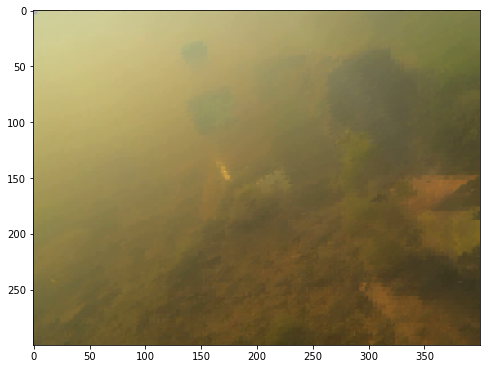

In [251]:
'''
First row -> only H pix
First col -> only V+Planar pix
Top left 4x4 -> avg pixel
Last col     -> no planar
'''

Iframe = np.zeros((300, 400, scaled.shape[2]), dtype=scaled.dtype)

# TOP LEFT CORNER
Iframe[0:4, 0:4] = np.mean(scaled[0:4, 0:4].flatten())

# FIRST ROW
for i in range(4, 400, 4):
    n = [0]*8
    n.extend(scaled[0:4, i-1])
    n.append(0)
    sad_best, best_mode, pred_block, diff_block = intra4x(scaled[0:4, i:i+4], n, 1, 0, 0, 0)
    Iframe[0:4, i:i+4] = pred_block

# FIRST COLUMN
for i in range(4, 300, 4):
    n = []
    n.extend(scaled[i-1, 0:4])
    n.extend(scaled[i-1, 4:8])
    n.extend([0]*5)
    sad_best, best_mode, pred_block, diff_block = intra4x(scaled[i:i+4, 0:4], n, 0, 1, 1, 0)
    Iframe[i:i+4, 0:4] = pred_block

# INTRA 16X16 OVER ENTIRE FRAME
for i in range(4, 300-16, 16):
    for j in range(4, 400-16, 16):
        sad_best, best_mode, cur, pred_block = intra16x(scaled[i:i+16, j:j+16], scaled[i-1, j:j+16], scaled[i:i+16, j-1], 1, 1)
        Iframe[i:i+16, j:j+16] = pred_block

# INTRA 4X4 OVER BOTTLE - HARDCODED
for i in range(20, 140, 4):
    for j in range(120, 200, 4):
        n = []
        n.extend(scaled[i-1, j:j+4])
        n.extend(scaled[i-1, j+4:j+8])
        n.extend(scaled[i:i+4, j-1])
        n.append(scaled[i-1][j-1])
        sad_best, best_mode, pred_block, diff_block = intra4x(scaled[i:i+4, j:j+4], n, 1, 1, 1, 1)
        Iframe[i:i+4, j:j+4] = pred_block

# INTRA 4X4 OVER ENTIRE FRAME
for i in range(4, 300, 4):
    for j in range(4, 400-4, 4):
        n = []
        n.extend(scaled[i-1, j:j+4])
        n.extend(scaled[i-1, j+4:j+8])
        n.extend(scaled[i:i+4, j-1])
        n.append(scaled[i-1][j-1])
        sad_best, best_mode, pred_block, diff_block = intra4x(scaled[i:i+4, j:j+4], n, 1, 1, 1, 1)
        Iframe[i:i+4, j:j+4] = pred_block
        
# LAST COLUMN
for i in range(4, 300, 4):
    n = []
    n.extend(scaled[i-1, 396:400])
    n.extend([0]*4)
    n.extend(scaled[i:i+4, 395])
    n.append(scaled[i-1][395])
    sad_best, best_mode, pred_block, diff_block = intra4x(scaled[i:i+4, 396:400], n, 1, 0, 1, 1)
    Iframe[i:i+4, 396:400] = pred_block
        
fig = plt.figure(figsize=(8, 8))
plt.imshow(Iframe)
plt.show()